In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

U-Net model works with convolution and spectrograms

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, input_channels=1, output_channels=9):
        super(UNet, self).__init__()

        # Helper function for creating a convolution block
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        # Encoder layers
        self.encoder1 = conv_block(input_channels, 16)
        self.encoder2 = conv_block(16, 64)
        self.encoder3 = conv_block(64, 128)

        # Middle layer
        self.middle = conv_block(128, 128)

        # Decoder layers
        self.decoder3 = conv_block(128 + 128, 128)
        self.decoder2 = conv_block(128 + 64, 64)
        self.decoder1 = conv_block(64 + 16, 16)

        # Final layer
        # self.final = nn.Conv2d(16, output_channels, kernel_size=1)
        self.final = nn.Sequential(
          nn.Conv2d(16, output_channels, kernel_size=1),
          nn.Sigmoid()  # 🚀 Ensures outputs are between 0 and 1
        )

        # Max pooling layer
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        # Encoder path
        e1 = self.encoder1(x)
        p1 = self.pool(e1)

        e2 = self.encoder2(p1)
        p2 = self.pool(e2)

        e3 = self.encoder3(p2)
        p3 = self.pool(e3)

        # Middle path
        mid = self.middle(p3)

        # Decoder path
        d3 = F.interpolate(mid, size=e3.shape[2:], mode='bilinear', align_corners=True)
        d3 = torch.cat([d3, e3], dim=1)  # Concatenate with encoder output
        d3 = self.decoder3(d3)

        d2 = F.interpolate(d3, size=e2.shape[2:], mode='bilinear', align_corners=True)
        d2 = torch.cat([d2, e2], dim=1)  # Concatenate with encoder output
        d2 = self.decoder2(d2)

        d1 = F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=True)
        d1 = torch.cat([d1, e1], dim=1)  # Concatenate with encoder output
        d1 = self.decoder1(d1)

        # Output layer
        out = self.final(d1)
        return out

Spectrogram Dataset Class

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
import soundfile as sf

class SpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, file_paths):
        """
        Initialize the dataset with the file paths of the mix and stems.
        Assumes the first file is the mix, followed by the stems.

        Args:
        - file_paths: List of file paths where the first is the mix and the rest are the stems.
        """
        self.mix_path = file_paths[0]  # First file is the mix
        self.stem_paths = file_paths[1:]  # Remaining files are the stems

    def __len__(self):
        return 1  # One sample per call (mix + stems)

    def __getitem__(self, idx):
        # Load mix audio
        y_mix, sr = librosa.load(self.mix_path, sr=44100)
        S_mix = librosa.stft(y_mix[:2000000])
        S_mix_amp = np.abs(S_mix)
        ref_value = np.max(S_mix_amp)  # Use mix's max amplitude as global reference

        S_mix_dB = librosa.amplitude_to_db(S_mix_amp, ref=ref_value)
        S_mix_dB = np.clip(S_mix_dB, -80, 0)  # Clip to typical dB range
        S_mix_dB_norm = (S_mix_dB + 80) / 80  # Normalize to [0, 1]

        mix_time_len = S_mix_dB_norm.shape[1]

        # Process stem files
        stems_spectrograms = []
        for stem_path in self.stem_paths:
            y_stem, _ = librosa.load(stem_path, sr=44100)
            # print(y_stem)
            sf.write("test_output.wav", y_stem, sr)  # Optional debug save
            S_stem = librosa.stft(y_stem[:2000000])
            S_stem_amp = np.abs(S_stem)
            S_stem_dB = librosa.amplitude_to_db(S_stem_amp, ref=ref_value)  # Use mix reference
            S_stem_dB = np.clip(S_stem_dB, -80, 0)
            S_stem_dB_norm = (S_stem_dB + 80) / 80  # Normalize to [0, 1]

            # Align shape with mix
            stem_time_len = S_stem_dB_norm.shape[1]
            if stem_time_len > mix_time_len:
                S_stem_dB_norm = S_stem_dB_norm[:, :mix_time_len]
            elif stem_time_len < mix_time_len:
                padding = mix_time_len - stem_time_len
                S_stem_dB_norm = np.pad(S_stem_dB_norm, ((0, 0), (0, padding)), mode='constant')

            stems_spectrograms.append(S_stem_dB_norm)

        # Convert to tensors
        mixed_tensor = torch.tensor(S_mix_dB_norm, dtype=torch.float32).unsqueeze(0)  # (1, freq, time)
        stems_tensor = torch.tensor(np.array(stems_spectrograms), dtype=torch.float32)  # (num_stems, freq, time)

        return mixed_tensor, stems_tensor


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Train Model

In [15]:
from tqdm import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
import os

torch.cuda.empty_cache()

num_epochs = 10
batch_size = 10

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
track_name = "Track00001"
mix_path = [os.path.join(project_root, "data", "raw", track_name, "mix.wav")]

stems_paths = [
    os.path.join(project_root, "data", "raw", track_name, "stems", "S00.wav"),
    os.path.join(project_root, "data", "raw", track_name, "stems", "S01.wav"),
    os.path.join(project_root, "data", "raw", track_name, "stems", "S02.wav"),
    os.path.join(project_root, "data", "raw", track_name, "stems", "S03.wav"),
    os.path.join(project_root, "data", "raw", track_name, "stems", "S04.wav"),
    os.path.join(project_root, "data", "raw", track_name, "stems", "S05.wav"),
    os.path.join(project_root, "data", "raw", track_name, "stems", "S07.wav"),
    os.path.join(project_root, "data", "raw", track_name, "stems", "S08.wav"),
    os.path.join(project_root, "data", "raw", track_name, "stems", "S09.wav"),
    os.path.join(project_root, "data", "raw", track_name, "stems", "S10.wav")
]
dataset = SpectrogramDataset(mix_path + stems_paths)

# dataset = SpectrogramDataset(["mix.wav", "S01.wav", "S02.wav", "S03.wav", "S04.wav", "S05.wav", "S07.wav", "S08.wav", "S09.wav", "S10.wav"])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model
num_stems = 10  # CHANGE THIS TO NOT BE HARDCODED
model = UNet(input_channels=1, output_channels=10).to(device)
criterion = nn.MSELoss().to(device) # Loss for spectrograms
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("model initialized")
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for mixed, stems in progress_bar:
        # mixed = mixed.to(device).requires_grad_(True)
        # stems = stems.to(device)
        transform = transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
        mixed = transform(mixed).to(device)
        stems = transform(stems).to(device)

        optimizer.zero_grad()
        outputs = model(mixed)
        outputs = outputs[..., :stems.shape[-1]]
        # print()
        # print("output shape: ", outputs.shape[0], ", ", outputs.shape[1])
        # print("stems shape: ", stems.shape[0], ", ", stems.shape[1])
        loss = criterion(outputs, stems)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        torch.cuda.empty_cache()
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()

model initialized


Epoch 1/10:   0%|          | 0/1 [00:00<?, ?batch/s]

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.4909678e-08
  1.8134457e-08 -6.6142407e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5438869e-06
  6.1885262e-06  5.1700335e-06]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


Epoch 1/10: 100%|██████████| 1/1 [00:44<00:00, 44.07s/batch, loss=2.1320]


Epoch 1, Loss: 2.1319808959960938


Epoch 2/10:   0%|          | 0/1 [00:00<?, ?batch/s]

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.4909678e-08
  1.8134457e-08 -6.6142407e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5438869e-06
  6.1885262e-06  5.1700335e-06]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


Epoch 2/10: 100%|██████████| 1/1 [00:47<00:00, 47.24s/batch, loss=2.1268]


Epoch 2, Loss: 2.1267786026000977


Epoch 3/10:   0%|          | 0/1 [00:00<?, ?batch/s]

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.4909678e-08
  1.8134457e-08 -6.6142407e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5438869e-06
  6.1885262e-06  5.1700335e-06]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


Epoch 3/10: 100%|██████████| 1/1 [00:47<00:00, 47.31s/batch, loss=2.1193]


Epoch 3, Loss: 2.119291067123413


Epoch 4/10:   0%|          | 0/1 [00:00<?, ?batch/s]

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.4909678e-08
  1.8134457e-08 -6.6142407e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5438869e-06
  6.1885262e-06  5.1700335e-06]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


Epoch 4/10: 100%|██████████| 1/1 [00:45<00:00, 45.73s/batch, loss=2.0973]


Epoch 4, Loss: 2.0973317623138428


Epoch 5/10:   0%|          | 0/1 [00:00<?, ?batch/s]

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.4909678e-08
  1.8134457e-08 -6.6142407e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5438869e-06
  6.1885262e-06  5.1700335e-06]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


Epoch 5/10: 100%|██████████| 1/1 [00:41<00:00, 41.98s/batch, loss=1.9795]


Epoch 5, Loss: 1.9795211553573608


Epoch 6/10:   0%|          | 0/1 [00:00<?, ?batch/s]

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.4909678e-08
  1.8134457e-08 -6.6142407e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5438869e-06
  6.1885262e-06  5.1700335e-06]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


Epoch 6/10: 100%|██████████| 1/1 [00:41<00:00, 41.99s/batch, loss=1.5408]


Epoch 6, Loss: 1.54081130027771


Epoch 7/10:   0%|          | 0/1 [00:00<?, ?batch/s]

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.4909678e-08
  1.8134457e-08 -6.6142407e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5438869e-06
  6.1885262e-06  5.1700335e-06]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


Epoch 7/10: 100%|██████████| 1/1 [00:38<00:00, 38.19s/batch, loss=1.2456]


Epoch 7, Loss: 1.245609164237976


Epoch 8/10:   0%|          | 0/1 [00:00<?, ?batch/s]

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.4909678e-08
  1.8134457e-08 -6.6142407e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5438869e-06
  6.1885262e-06  5.1700335e-06]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


Epoch 8/10: 100%|██████████| 1/1 [00:39<00:00, 39.08s/batch, loss=1.2445]


Epoch 8, Loss: 1.2444922924041748


Epoch 9/10:   0%|          | 0/1 [00:00<?, ?batch/s]

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.4909678e-08
  1.8134457e-08 -6.6142407e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5438869e-06
  6.1885262e-06  5.1700335e-06]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


Epoch 9/10: 100%|██████████| 1/1 [06:11<00:00, 371.81s/batch, loss=1.2446]


Epoch 9, Loss: 1.24463951587677


Epoch 10/10:   0%|          | 0/1 [00:00<?, ?batch/s]

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.4909678e-08
  1.8134457e-08 -6.6142407e-09]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.5438869e-06
  6.1885262e-06  5.1700335e-06]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


Epoch 10/10: 100%|██████████| 1/1 [00:43<00:00, 43.90s/batch, loss=1.2447]


Epoch 10, Loss: 1.244664192199707


: 

Plot output spectrograms

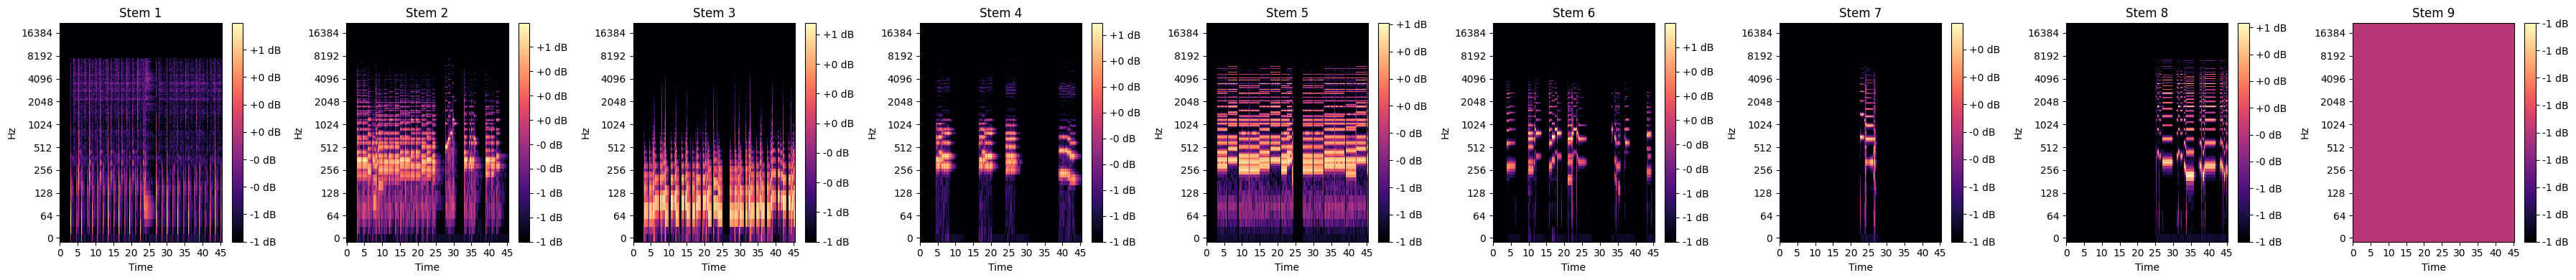

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

# stems is likely shaped (batch, num_stems, freq, time)
# So we extract the first batch
stem_spectrogram = stems[0].detach().cpu().numpy()  # shape: (num_stems, freq, time)

# Parameters
sr = 44100
hop_length = 512
num_stems = stem_spectrogram.shape[0]

# Plot
fig, axes = plt.subplots(1, num_stems, figsize=(4 * num_stems, 4), squeeze=False)

for i in range(num_stems):
    ax = axes[0, i]
    img = librosa.display.specshow(
        stem_spectrogram[i],  # shape: (freq, time)
        sr=sr,
        hop_length=hop_length,
        x_axis='time',
        y_axis='log',
        cmap='magma',
        ax=ax
    )
    ax.set_title(f"Stem {i+1}")
    fig.colorbar(img, ax=ax, format="%+2.0f dB")

plt.tight_layout()
plt.show()

# import matplotlib.pyplot as plt

# stem_spectrogram = stems[0].detach().cpu().numpy()

# fig, axes = plt.subplots(1, stem_spectrogram.shape[0], figsize=(15, 4))
# for i in range(stem_spectrogram.shape[0]):
#     axes[i].imshow(stem_spectrogram[i], aspect='auto', origin='lower', cmap='magma')
#     axes[i].set_title(f"Stem {i+1} Spectrogram")

# plt.show()

# idx = 0
# pred_spectrogram = outputs[idx].detach().cpu().numpy()
# true_spectrogram = stems[idx].detach().cpu().numpy()

# # Plot the spectrograms
# fig, axes = plt.subplots(2, 1, figsize=(10, 6))
# axes[0].imshow(true_spectrogram[0], aspect='auto', origin='lower', cmap='magma')
# axes[0].set_title("Ground Truth Spectrogram")
# axes[1].imshow(pred_spectrogram[0], aspect='auto', origin='lower', cmap='magma')
# axes[1].set_title("Predicted Spectrogram")
# plt.show()

Helper function to play audio from a spectrogram

In [ ]:
import IPython.display as ipd
import torchaudio
import torchaudio.transforms as T
import numpy as np
def spectrogram_to_audio(spectrogram, n_fft=1024, hop_length=512):
    """
    Convert a spectrogram back to audio using Griffin-Lim.

    Args:
        spectrogram (Tensor): The predicted spectrogram from the model (shape: [batch, channels, freq, time]).
        n_fft (int): FFT size (should match what was used in training).
        hop_length (int): Hop length (should match training).

    Returns:
        numpy.ndarray: The reconstructed waveform.
    """
    # Move to CPU and detach from computation graph
    spectrogram = spectrogram.cpu().detach()

    # Ensure the spectrogram is at least 2D (batch dimension might be missing)
    if spectrogram.dim() == 3:  # If missing batch dimension, add it
        spectrogram = spectrogram.unsqueeze(0)

    # Check if spectrogram is all zeros (avoid computation on empty audio)
    if torch.all(spectrogram == 0):
        print("Warning: Received an all-zero spectrogram.")
        return np.zeros((1, spectrogram.shape[-1] * hop_length))

    # If spectrogram is in dB, convert back to magnitude
    transform = T.InverseMelScale(n_stft=spectrogram.shape[-2], n_mels=spectrogram.shape[-2])
    spectrogram = transform(spectrogram)

    # Griffin-Lim to reconstruct audio
    griffin_lim = T.GriffinLim(n_fft=n_fft, hop_length=hop_length)
    waveform = griffin_lim(spectrogram)

    return waveform.numpy()

Play the outputed stems

In [ ]:
# for i in range(stems.shape[1]):  # Loop over stems
#     stem_audio = spectrogram_to_audio(outputs[:, i])  # Convert spectrogram to waveform
#     ipd.display(ipd.Audio(stem_audio, rate=22050))  # Play audio